<a href="https://colab.research.google.com/github/TZKee/TensorFlow-Project-GeneralMagic/blob/main/AiGrijaLaGroapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U --pre tensorflow=="2.2.0"

import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

     |████████████████████████████████| 516.2MB 32kB/s 
     |████████████████████████████████| 3.0MB 24.2MB/s 
     |████████████████████████████████| 460kB 30.2MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1
Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2204/2204), done.
remote: Total 2650 (delta 674), reused 1302 (delta 414), pack-reused 0
Receiving objects: 100% (2650/2650), 32.62 MiB | 30.17 MiB/s, done.
Resolving deltas: 100% (674/674), done.


In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

#run model builder test
python /content/models/research/object_detection/builders/model_builder_tf2_test.py

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1650058 sha256=87aa9549efab505d572eda5b942df409670349d11bc581aaf79eac37bde2f5f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-m8fhcdw4/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.2-cp37-none-any.whl size=44011 sha256=772c4c8f53990b496a573216553ebc77a5d2b045cfc1e462b19c631246135b85
  Stored in directory: /root/.cache/pip/wheels/ee/ee/18/c466221ca6900e3efce2f4ea9c329288808679aecdcb2838d3
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=8b54a2ab116e600f22a62b80bb11b1a0c4afcf9672c80cf7dee3af39afd269e9
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for dill: filename=dill-0.3.1.1-cp37-none-any.whl size=78532 sha256=00270ad9997829500c2f400b096febbecf0f7ec78e44fcd3bfcf

ERROR: tensorflow 2.5.0 has requirement grpcio~=1.34.0, but you'll have grpcio 1.32.0 which is incompatible.
ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.29.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.
2021-05-20 10:53:40.613345: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Running tests under Python 3.7.10: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2021-05-20 10:53:43.345945: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-05-20 10:5

In [ ]:
# Install Kaggle API
!pip install -q kaggle

from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d chitholian/annotated-potholes-dataset --unzip



Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes
 89% 41.0M/45.9M [00:00<00:00, 77.4MB/s]
100% 45.9M/45.9M [00:00<00:00, 103MB/s] 


In [ ]:
import os, sys, shutil, fnmatch, random, json
import xml.etree.ElementTree as ET
import numpy as np
import tensorflow as tf
#@title Split Dataset into Train and Test.

DATASET_PATH = '/content' #@param {type:'string'}
TEST_RATIO = 0.2 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
FORCE_RESPLIT = False #@param {type:"boolean"}

IMAGES_PATH = os.path.join(DATASET_PATH, 'annotated-images')

if not os.path.exists(DATASET_PATH):
    !kaggle datasets download -p archives chitholian/annotated-potholes-dataset
    !unzip -qd "{DATASET_PATH}" "archives/annotated-potholes-dataset.zip"

if FORCE_RESPLIT or not os.path.exists(os.path.join(DATASET_PATH, 'splits.json')):
    all_xmls = fnmatch.filter(os.listdir(IMAGES_PATH), '*.xml')
    total_size = len(all_xmls)
    max_test_ratio = (total_size - 1)/total_size  # Training set must have at least 1 member.
    assert 0 <= TEST_RATIO <= max_test_ratio, f'TEST_RATIO must be in range [0, {max_test_ratio}]'
    test_set = set()
    train_set = set()
    while len(test_set) < round(total_size * TEST_RATIO):
        test_set.add(all_xmls[random.randint(0, total_size - 1)])
    for xml in all_xmls:
        if xml not in test_set:
            train_set.add(xml)
    with open(os.path.join(DATASET_PATH, 'splits.json'), 'w') as f:
        json.dump({'train': list(train_set), 'test': list(test_set)}, f)
        print(f'Splits written to "{f.name}"')
else:
    with open(os.path.join(DATASET_PATH, 'splits.json'), 'r') as f:
        splits = json.load(f)
        train_set = splits['train']
        test_set = splits['test']

print('-----Training Set', train_set)
print('-----Test Set', test_set)

-----Training Set ['img-110.xml', 'img-578.xml', 'img-455.xml', 'img-87.xml', 'img-213.xml', 'img-369.xml', 'img-37.xml', 'img-59.xml', 'img-83.xml', 'img-431.xml', 'img-474.xml', 'img-370.xml', 'img-227.xml', 'img-661.xml', 'img-552.xml', 'img-433.xml', 'img-36.xml', 'img-316.xml', 'img-273.xml', 'img-659.xml', 'img-500.xml', 'img-561.xml', 'img-512.xml', 'img-251.xml', 'img-508.xml', 'img-522.xml', 'img-353.xml', 'img-392.xml', 'img-100.xml', 'img-229.xml', 'img-643.xml', 'img-208.xml', 'img-261.xml', 'img-204.xml', 'img-295.xml', 'img-258.xml', 'img-195.xml', 'img-424.xml', 'img-63.xml', 'img-94.xml', 'img-443.xml', 'img-377.xml', 'img-43.xml', 'img-397.xml', 'img-385.xml', 'img-269.xml', 'img-216.xml', 'img-73.xml', 'img-610.xml', 'img-246.xml', 'img-541.xml', 'img-13.xml', 'img-356.xml', 'img-655.xml', 'img-220.xml', 'img-360.xml', 'img-214.xml', 'img-484.xml', 'img-237.xml', 'img-347.xml', 'img-632.xml', 'img-550.xml', 'img-535.xml', 'img-413.xml', 'img-477.xml', 'img-592.xml', '

In [ ]:
#@title Some Useful Functions

def download_file(url, save_as, continue_existing=True):
    if continue_existing:
        !wget -c "{url}" -O "{save_as}"
    else:
        !wget "{url}" -O "{save_as}"

In [ ]:
#@title Download Tensorflow Models Repository

if not os.path.exists('models'):
    download_file('https://github.com/tensorflow/models/archive/master.zip', 'archives/models.zip', continue_existing=False)
    !unzip -qnd archives "archives/models.zip" && mv archives/models-* models

!cd models/research && protoc object_detection/protos/*.proto --python_out=.

In [ ]:
#@title Create LabelMap and TFRECORD Files

LABELS = ['pothole']  #@param {type:"raw"}
FORCE_RECREATE = False  #@param {type:"boolean"}

with open('annotations/labels.pbtxt', 'w') as f:
    for i in range(len(LABELS)):
        f.write(f'''\
item {{
    id: {i + 1}
    name: "{LABELS[i]}"
}}
''')

def class_text_to_int(class_name):
    try:
        return LABELS.index(class_name) + 1
    except:
        return None

def create_tfrecord(xml_files, output_file):
    writer = tf.io.TFRecordWriter(output_file)

    for xml_file in xml_files:
        tree = ET.parse(os.path.join(IMAGES_PATH, xml_file))
        root = tree.getroot()

        width = int(root.find('size/width').text)
        height = int(root.find('size/height').text)
        filename = root.find('filename').text.encode('utf8')
        image_format = root.find('filename').text.split('.')[-1].encode('utf8')

        with tf.io.gfile.GFile(os.path.join(IMAGES_PATH, root.find('filename').text), 'rb') as fid:
            encoded_img = fid.read()

        class_names = []
        class_ids = []
        xmins = []
        ymins = []
        xmaxs= []
        ymaxs = []
        truncated = []
        difficulties = []

        for m in root.iter('object'):
            class_names.append(m.find('name').text.encode('utf8'))
            class_ids.append(int(class_text_to_int(m.find('name').text)))
            xmins.append(int(m.find('bndbox/xmin').text) / width)
            ymins.append(int(m.find('bndbox/ymin').text) / height)
            xmaxs.append(int(m.find('bndbox/xmax').text) / width)
            ymaxs.append(int(m.find('bndbox/ymax').text) / height)
            truncated.append(int(m.find('truncated').text))
            difficulties.append(int(m.find('difficult').text))

        tf_example = tf.train.Example(features=tf.train.Features(feature={
            'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
            'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
            'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename])),
            'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename])),
            'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_img])),
            'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_format])),
            'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmins)),
            'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmaxs)),
            'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymins)),
            'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymaxs)),
            'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=class_names)),
            'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=class_ids)),
            'image/object/truncated': tf.train.Feature(int64_list=tf.train.Int64List(value=truncated)),
            'image/object/difficult': tf.train.Feature(int64_list=tf.train.Int64List(value=difficulties))
        }))

        writer.write(tf_example.SerializeToString())

    writer.close()
    print('Created tfrecord file:', output_file)

if FORCE_RECREATE or not os.path.exists('annotations/training.record'):
    create_tfrecord(train_set, 'annotations/training.record')
if FORCE_RECREATE or not os.path.exists('annotations/evaluation.record'):
    create_tfrecord(test_set, 'annotations/evaluation.record')

Created tfrecord file: annotations/training.record
Created tfrecord file: annotations/evaluation.record


In [ ]:
train_record_path = '/content/annotations/training.record'
test_record_path = '/content/annotations/evaluation.record'
labelmap_path = '/content/annotations/labels.pbtxt'

In [ ]:
batch_size = 16
num_steps = 1500
num_eval_steps = 100

# Get the model from: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md
MODEL = 'ssd_mobilenet_v2_320x320_coco17_tpu-8'

!wget 'http://download.tensorflow.org/models/object_detection/tf2/20200711/{MODEL}.tar.gz'
!tar -xf '{MODEL}.tar.gz'

fine_tune_checkpoint = f'{MODEL}/checkpoint/ckpt-0'

!wget 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/{MODEL}.config'
base_config_path = f'{MODEL}.config'

# edit configuration file (from https://colab.research.google.com/drive/1sLqFKVV94wm-lglFq_0kGo2ciM0kecWD)

import re

with open(base_config_path) as f:
    config = f.read()

with open('model_config.config', 'w') as f:
  
  # Set labelmap path
  config = re.sub('label_map_path: ".*?"', 
             'label_map_path: "{}"'.format(labelmap_path), config)
  
  # Set fine_tune_checkpoint path
  config = re.sub('fine_tune_checkpoint: ".*?"',
                  'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), config)
  
  # Set train tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 
                  'input_path: "{}"'.format(train_record_path), config)
  
  # Set test tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 
                  'input_path: "{}"'.format(test_record_path), config)
  
  # Set number of classes.
  config = re.sub('num_classes: [0-9]+',
                  'num_classes: {}'.format(4), config)
  
  # Set batch size
  config = re.sub('batch_size: [0-9]+',
                  'batch_size: {}'.format(batch_size), config)
  
  # Set training steps
  config = re.sub('num_steps: [0-9]+',
                  'num_steps: {}'.format(num_steps), config)
  
  # Set fine-tune checkpoint type to detection
  config = re.sub('fine_tune_checkpoint_type: "classification"', 
             'fine_tune_checkpoint_type: "{}"'.format('detection'), config)
  
  f.write(config)

%cat model_config.config

--2021-05-20 10:56:41--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.204.128, 2607:f8b0:400c:c15::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.204.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46042990 (44M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_32 100%[===================>]  43.91M   198MB/s    in 0.2s    

2021-05-20 10:56:41 (198 MB/s) - ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz’ saved [46042990/46042990]

--2021-05-20 10:56:42--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/ssd_mobilenet_v2_320x320_coco17_tpu-8.config
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent

In [ ]:
model_dir = 'training/'
pipeline_config_path = 'model_config.config'

!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_config_path} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={num_eval_steps}

2021-05-20 10:57:13.329533: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-05-20 10:57:15.782434: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-05-20 10:57:15.794448: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-20 10:57:15.794505: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (339915bc2adb): /proc/driver/nvidia/version does not exist
2021-05-20 10:57:15.794968: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0520 

In [ ]:
 # %load_ext tensorboard
 # %tensorboard --logdir '/content/training/train'

In [ ]:
output_directory = 'inference_graph'

!python /content/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {model_dir} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_config_path}

2021-05-20 13:29:03.290668: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-05-20 13:29:05.640446: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-05-20 13:29:05.653847: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-20 13:29:05.653926: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (339915bc2adb): /proc/driver/nvidia/version does not exist
2021-05-20 13:29:05.654381: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Instru

In [ ]:
tflite_directory='tflite_directory'

!python /content/models/research/object_detection/export_tflite_graph_tf2.py \
    --pipeline_config_path={pipeline_config_path} \
    --output_directory={tflite_directory} \
    --trained_checkpoint_dir=/content/training

2021-05-20 13:30:18.375541: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-05-20 13:30:20.708581: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-05-20 13:30:20.722355: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-20 13:30:20.722418: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (339915bc2adb): /proc/driver/nvidia/version does not exist
2021-05-20 13:30:20.722859: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:t

In [ ]:
 from google.colab import files
 files.download(f'/content/{output_directory}/saved_model/saved_model.pb') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

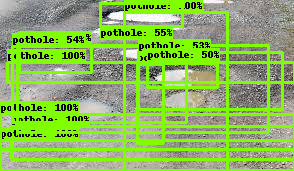

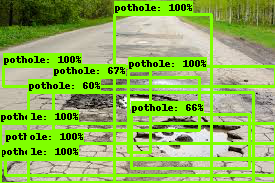

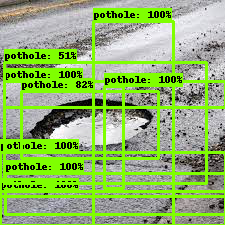

In [ ]:
import io
import os
import scipy.misc
import numpy as np
import six
import time
import glob
from IPython.display import display

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

%matplotlib inline

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)

tf.keras.backend.clear_session()
model = tf.saved_model.load(f'/content/{output_directory}/saved_model')

def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed < 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

for image_path in glob.glob('/content/test/*.jpg'):
  image_np = load_image_into_numpy_array(image_path)
  output_dict = run_inference_for_single_image(model, image_np)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=3)
  display(Image.fromarray(image_np))

In [ ]:
# tflite_convert \
# --input_shape=1,640,640,3 \
# --input_arrays=normalized_input_image_tensor \
# --output_arrays=TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3 \
# --allow_custom_ops --graph_def_file=/content/inference_graph/saved_model/saved_model.pb \
# --output_file=detect.tflite
# !tflite_convert \
# --saved_model_dir=/content/inference_graph/saved_model \
# --output_file=model.tflite

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model('/content/tflite_directory/saved_model/',signature_keys=['serving_default'])

# converter.experimental_new_converter = True
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
# converter.allow_custom_ops=True

tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

from google.colab import files
files.download('model.tflite') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install tflite_support_nightly

     |████████████████████████████████| 1.1MB 6.6MB/s 
     |████████████████████████████████| 194kB 9.6MB/s 


In [ ]:
from tflite_support.metadata_writers import object_detector
from tflite_support.metadata_writers import writer_utils
from tflite_support import metadata

ObjectDetectorWriter = object_detector.MetadataWriter
_MODEL_PATH = "model.tflite"
_LABEL_FILE = "annotations/label.txt"
_SAVE_TO_PATH = "model_metadata.tflite"

writer = ObjectDetectorWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [127.5], [127.5], [_LABEL_FILE])
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

# Verify the populated metadata and associated files.
displayer = metadata.MetadataDisplayer.with_model_file(_SAVE_TO_PATH)
print("Metadata populated:")
print(displayer.get_metadata_json())
print("Associated file(s) populated:")
print(displayer.get_packed_associated_file_list())

files.download('model_metadata.tflite')

Metadata populated:
{
  "name": "ObjectDetector",
  "description": "Identify which of a known set of objects might be present and provide information about their positions within the given image or a video stream.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be detected.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>